In [1]:
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import boto3
import sagemaker
import numpy as np

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[12/17/24 00:07:16] INFO     Found credentials from IAM Role:                                   ]8;id=699984;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=609421;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [3]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
images[0]

'scottish_terrier_93.jpg'

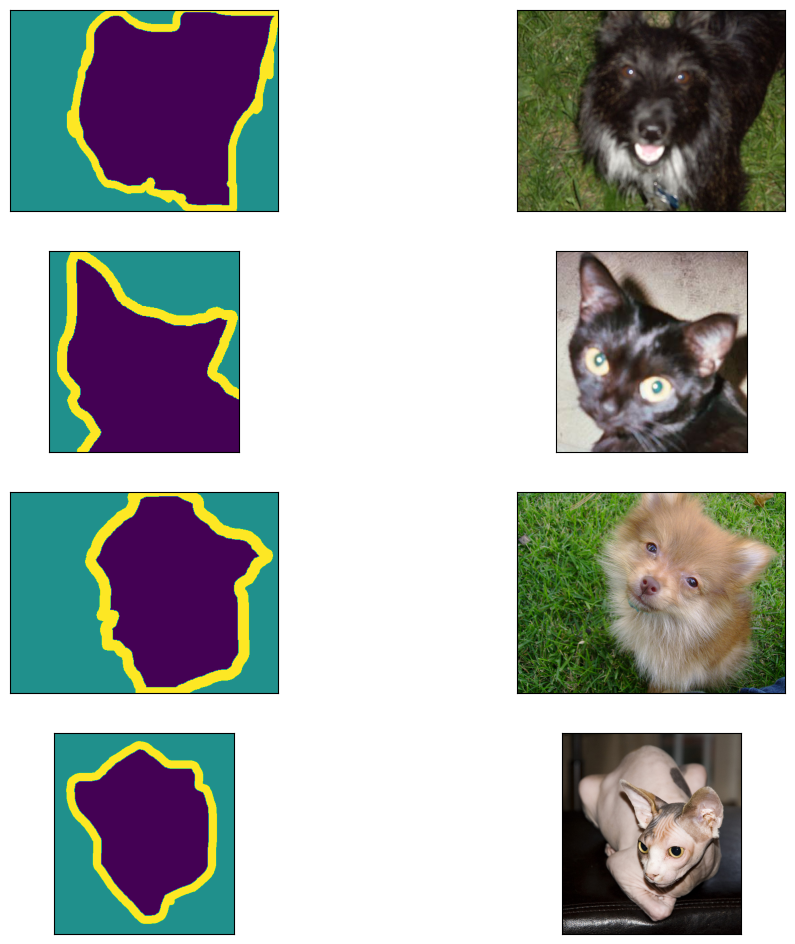

In [6]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [7]:
from PIL import Image
valid_maps = [f for f in maps if not f.startswith('._') and os.path.isfile(os.path.join(trimaps_dir, f))]
if valid_maps:
    img = Image.open(os.path.join(trimaps_dir, valid_maps[0]))
    print(np.unique(img))

[1 2 3]


In [8]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdatamodel'
from sagemaker import image_uris

training_image = image_uris.retrieve(
    framework='semantic-segmentation',
    region='us-east-2',
    version='latest'
)

[12/17/24 00:07:20] INFO     Found credentials from IAM Role:                                   ]8;id=598840;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=916952;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=500403;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=445237;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#387\387]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=403275;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=110371;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#524\524]8;;\

In [9]:
print(training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [11]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:11<00:00, 616.33it/s] 


In [12]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [13]:
print(len(train_annots), len(train_images))

5500 5500


In [14]:
sess = sagemaker.Session()

[12/17/24 00:07:33] INFO     Found credentials from IAM Role:                                   ]8;id=898606;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=287864;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [15]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import BytesDeserializer

predictor = sagemaker.predictor.Predictor(
    endpoint_name='semantic-segmentation-2024-12-16-23-35-17-352',
    serializer=IdentitySerializer(content_type="image/jpeg"),
    deserializer=BytesDeserializer(),
)
predictor.content_type = "image/jpeg"
predictor.accept = "image/png"

[12/17/24 00:07:34] INFO     Found credentials from IAM Role:                                   ]8;id=831682;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=90431;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [16]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1890


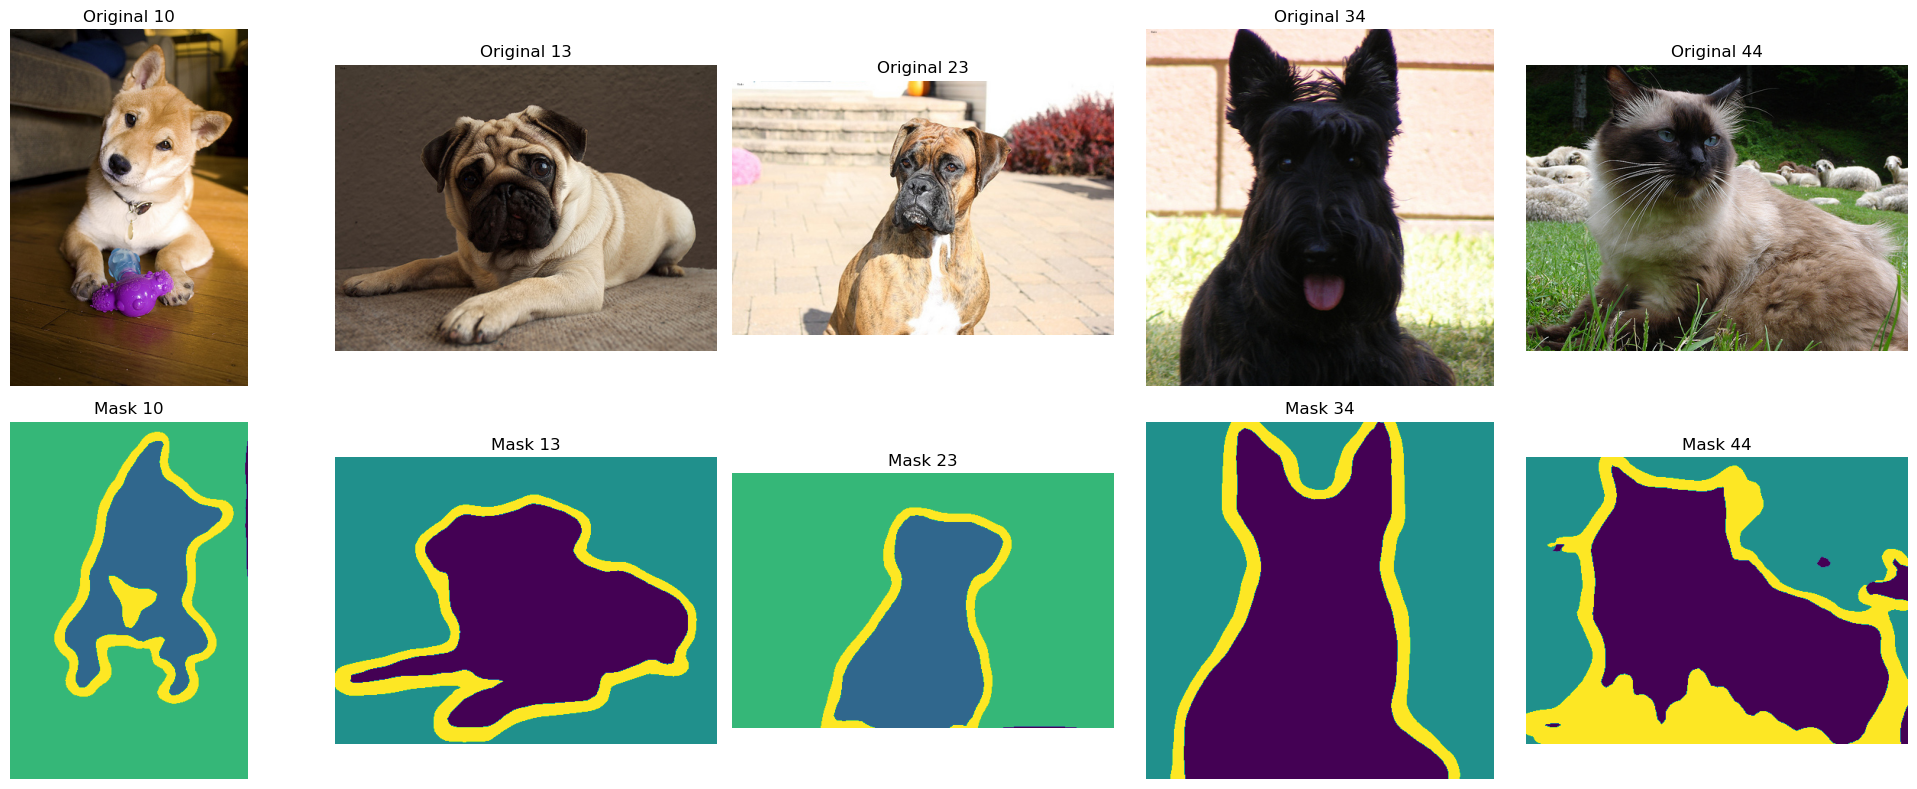

In [17]:
indices = [10, 13, 23, 34, 44]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for idx, image_idx in enumerate(indices):
    image_path = os.path.join(image_dir, images[image_idx])
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
    results = predictor.predict(b)
    
    axes[0, idx].imshow(plt.imread(image_path))
    axes[0, idx].set_title(f'Original {image_idx}')
    axes[0, idx].axis('off')
    
    mask = np.array(Image.open(io.BytesIO(results)))
    axes[1, idx].imshow(mask)
    axes[1, idx].set_title(f'Mask {image_idx}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

In [18]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

[12/17/24 00:08:25] INFO     Found credentials from IAM Role:                                   ]8;id=542102;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=509751;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[12/17/24 00:08:26] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=193739;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=105400;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Deleting endpoint with name:                                           ]8;id=887146;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=916304;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4855\4855]8;;\
                             semantic-segmentation-2024-12-16-23-35-17-352                                         